Step 1: Required Libraries

In [1]:
# Required libraries
import pandas as pd
from datasets import Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
import gensim.downloader as api
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


Step 2: Reading the File and Preprocessing

In [ ]:
# Read the data and drop the first column 
df = pd.read_csv('text.csv')

df = df.drop(columns=['Unnamed: 0'])

print(df)

                                                     text  label
0           i just feel really helpless and heavy hearted      4
1       ive enjoyed being able to slouch about relax a...      0
2       i gave up my internship with the dmrg and am f...      4
3                              i dont know i feel so lost      0
4       i am a kindergarten teacher and i am thoroughl...      4
...                                                   ...    ...
416834                                       smiling face      2
416835                                          thumbs up      1
416836                                          thumbs up      1
416837                                          thumbs up      1
416838                                          thumbs up      1

[416839 rows x 2 columns]


In [3]:
# Split data into 3 parts train (80%), validate (10%) and test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print("Training set size:", train_df.shape)
print("Validation set size:", validate_df.shape)
print("Test set size:", test_df.shape)

Training set size: (333471, 2)
Validation set size: (41684, 2)
Test set size: (41684, 2)


In [4]:
# Download the stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add('im')  
print(stop_words)

{'does', 'once', 'into', 'are', "she'll", 'wouldn', 'itself', 'weren', 'a', "i'll", 'be', 'yours', "shan't", "isn't", 't', "wouldn't", 'just', 'she', 'shan', "hadn't", "i'm", 'himself', "he's", 'i', 'above', 'from', "they'll", 're', 'such', 'there', 'more', 'y', 'against', 'nor', "they've", 'me', "weren't", 'it', 'then', 'up', 'hers', 'own', 'haven', 'having', 'which', 'as', 'during', 'had', 'how', 'ma', 'they', "it'd", 'has', 'should', 'themselves', 'where', "won't", 'm', 'ourselves', 'wasn', 'shouldn', 'being', 'my', 'do', 'each', 'is', 'your', "doesn't", 'or', 'to', "haven't", 'ain', "he'd", 'couldn', "it'll", "hasn't", 'over', 'so', 'what', 'why', 'll', 'through', "they're", 'no', 'most', "we're", 'he', 'yourselves', "you're", 'were', "we'd", 'in', 'again', 'myself', 'ours', "he'll", 'if', 'those', 'of', "wasn't", 'yourself', 'some', "we'll", 'after', 'doing', 'needn', 'have', "you'll", 'did', 'its', 'before', 'but', 'than', "mightn't", 'this', 'been', 'at', "that'll", 'can', 'by',

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssemi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Remove the stopwords from each data frame
nltk.download('punkt')

for index, row in train_df.iterrows():
    word_tokens = word_tokenize(row["text"])
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = " ".join(filtered_sentence)
    train_df.at[index, "text"] = filtered_sentence
    
for index, row in test_df.iterrows():
    word_tokens = word_tokenize(row["text"])
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = " ".join(filtered_sentence)
    test_df.at[index, "text"] = filtered_sentence

for index, row in validate_df.iterrows():
    word_tokens = word_tokenize(row["text"])
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = " ".join(filtered_sentence)
    validate_df.at[index, "text"] = filtered_sentence


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssemi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Encoding the labels with one hot encoder 
cat_encoder = OneHotEncoder()

array_label_train = train_df["label"].values
array_label_test = test_df["label"].values
array_label_validate = validate_df["label"].values

array_label_train = array_label_train.reshape(-1, 1)
array_label_test = array_label_test.reshape(-1, 1)
array_label_validate = array_label_validate.reshape(-1, 1)

label_cat_1hot_train = cat_encoder.fit_transform(array_label_train)
label_cat_1hot_test = cat_encoder.fit_transform(array_label_test)
label_cat_1hot_validate = cat_encoder.fit_transform(array_label_validate)

train_df["label"] = list(label_cat_1hot_train.toarray())
test_df["label"] = list(label_cat_1hot_test.toarray())
validate_df["label"] = list(label_cat_1hot_validate.toarray())

In [7]:
# Print to preview
print(train_df.head(5))
print(test_df.head(5))
print(validate_df.head(5))

                                                     text  \
346568       suggest women feel inadequate every time log   
263107  feel helpless cant take anymore feel like stra...   
295879                    feel terrible things forgot say   
222094                                       ill feel bad   
410739         still feel paranoid mother mode destroy us   

                                 label  
346568  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
263107  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
295879  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
222094  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
410739  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]  
                                                     text  \
128011  pretty sure discussing whole thing public spac...   
236494  feel embarrassed humiliated korean attack vict...   
286327  feel like boasting haha love eyes sarcastic br...   
62027                           came home feeling drained   
17059   still feel theyd rather make money offend clie...   

                    

Step 3 - Part 1: Naive Bayes with Bag of Words / TF-IDF

Alpha=0.1 | Validation Accuracy: 0.8637
Alpha=0.5 | Validation Accuracy: 0.8635
Alpha=1.0 | Validation Accuracy: 0.8638
Alpha=5.0 | Validation Accuracy: 0.8630

Best Alpha: 1.0 with Validation Accuracy: 0.8638

Final Test Accuracy: 0.8640965358410901

Final Test Classification Report - Naive Bayes:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     12119
           1       0.86      0.92      0.89     14107
           2       0.81      0.72      0.76      3456
           3       0.89      0.81      0.85      5732
           4       0.84      0.79      0.82      4771
           5       0.80      0.72      0.76      1499

    accuracy                           0.86     41684
   macro avg       0.85      0.81      0.83     41684
weighted avg       0.86      0.86      0.86     41684



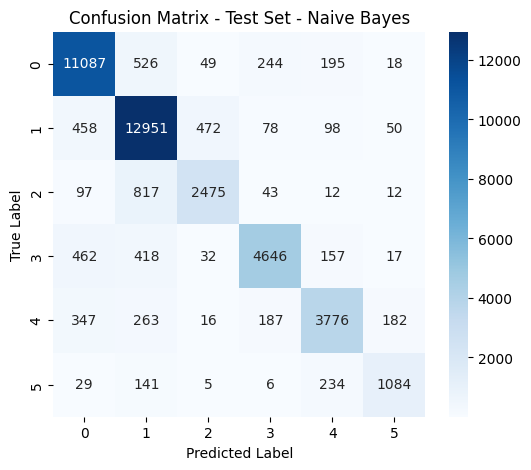

In [ ]:
# Use bag of words approach
vectorizer = CountVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
X_val = vectorizer.transform(validate_df['text'])

# Convert labels into numeric as naive bayes does not use one hot encoded labels
y_train = np.argmax(np.array(train_df['label'].tolist()), axis=1)
y_test = np.argmax(np.array(test_df['label'].tolist()), axis=1)
y_val = np.argmax(np.array(validate_df['label'].tolist()), axis=1)

# Hyperparameter tuning using validation dataset
alpha_values = [0.1, 0.5, 1.0, 5.0]
best_alpha = None
best_val_acc = 0
best_model_nb = None

for alpha in alpha_values:
    classifier_nb = MultinomialNB(alpha=alpha)  # Alpha is the smoothing parameter that can be adjusted
    classifier_nb.fit(X_train, y_train)  
    
    y_val_pred = classifier_nb.predict(X_val)  # Predictions
    val_acc = accuracy_score(y_val, y_val_pred)  # Validation accuracy calculated
    
    print(f"Alpha={alpha} | Validation Accuracy: {val_acc:.4f}")

    # Remove the bad performing model until the best performing model is reached
    if val_acc > best_val_acc:
        best_alpha = alpha
        best_val_acc = val_acc
        best_model_nb = classifier_nb

print(f"\nBest Alpha: {best_alpha} with Validation Accuracy: {best_val_acc:.4f}")

# Test using the best model on set
y_test_pred = best_model_nb.predict(X_test)

print("\nFinal Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nFinal Test Classification Report - Naive Bayes:\n", classification_report(y_test, y_test_pred))

# Confusion matrix calculation for further analysis of model on test set
test_cm_nb = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set - Naive Bayes - BoW")
plt.show()

Alpha=0.1 | Validation Accuracy: 0.8454
Alpha=0.5 | Validation Accuracy: 0.8452
Alpha=1.0 | Validation Accuracy: 0.8448
Alpha=5.0 | Validation Accuracy: 0.8407

Best Alpha: 0.1 with Validation Accuracy: 0.8454

Final Test Accuracy: 0.8455282602437386

Final Test Classification Report - Naive Bayes:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90     12119
           1       0.79      0.96      0.87     14107
           2       0.96      0.52      0.67      3456
           3       0.93      0.76      0.83      5732
           4       0.87      0.74      0.80      4771
           5       0.96      0.44      0.61      1499

    accuracy                           0.85     41684
   macro avg       0.89      0.73      0.78     41684
weighted avg       0.86      0.85      0.84     41684



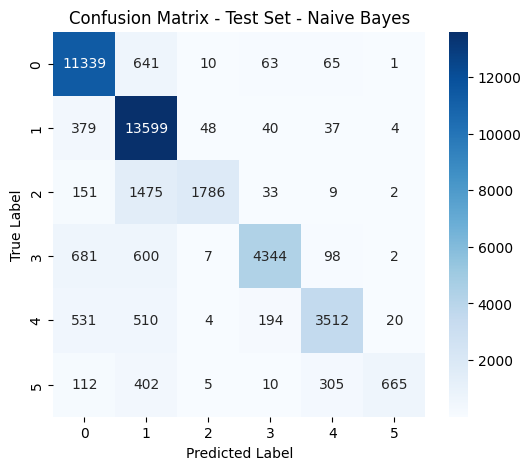

In [ ]:
# Use TF-IDF approach
vectorizer = TfidfVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
X_val = vectorizer.transform(validate_df['text'])

# Convert labels into numeric as naive bayes does not use one hot encoded labels
y_train = np.argmax(np.array(train_df['label'].tolist()), axis=1)
y_test = np.argmax(np.array(test_df['label'].tolist()), axis=1)
y_val = np.argmax(np.array(validate_df['label'].tolist()), axis=1)

# Hyperparameter tuning using validation dataset
alpha_values = [0.1, 0.5, 1.0, 5.0]
best_alpha = None
best_val_acc = 0
best_model_nb = None

for alpha in alpha_values:
    classifier_nb = MultinomialNB(alpha=alpha)  # Alpha is the smoothing parameter that can be adjusted
    classifier_nb.fit(X_train, y_train)  
    
    y_val_pred = classifier_nb.predict(X_val)  # Predictions
    val_acc = accuracy_score(y_val, y_val_pred)  # Validation accuracy calculated
    
    print(f"Alpha={alpha} | Validation Accuracy: {val_acc:.4f}")

    # Remove the bad performing model until the best performing model is reached
    if val_acc > best_val_acc:
        best_alpha = alpha
        best_val_acc = val_acc
        best_model_nb = classifier_nb

print(f"\nBest Alpha: {best_alpha} with Validation Accuracy: {best_val_acc:.4f}")

# Test using the best model on set
y_test_pred = best_model_nb.predict(X_test)

print("\nFinal Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nFinal Test Classification Report - Naive Bayes:\n", classification_report(y_test, y_test_pred))

# Confusion matrix calculation for further analysis of model on test set
test_cm_nb = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set - Naive Bayes - TF-IDF")
plt.show()

Step 3 - Part 2: Linear Support Vector Machines with Bag of Words / TF-IDF

C=0.1 | Validation Accuracy: 0.8671


c:\Users\ssemi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=0.5 | Validation Accuracy: 0.8676


c:\Users\ssemi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=1.0 | Validation Accuracy: 0.8674


c:\Users\ssemi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=5.0 | Validation Accuracy: 0.8676

Best C: 5.0 with Validation Accuracy: 0.8676

Final Test Accuracy: 0.8663755877554937

Final Test Classification Report - Support Vector Machines:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92     12119
           1       0.84      0.93      0.88     14107
           2       0.80      0.74      0.77      3456
           3       0.88      0.83      0.85      5732
           4       0.85      0.79      0.82      4771
           5       0.77      0.74      0.75      1499

    accuracy                           0.87     41684
   macro avg       0.84      0.82      0.83     41684
weighted avg       0.87      0.87      0.87     41684



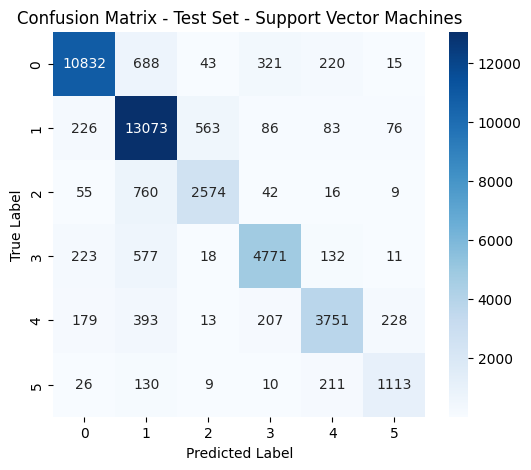

In [ ]:
# Use bag of words approach
vectorizer = CountVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
X_val = vectorizer.transform(validate_df['text'])

# Convert labels into numeric as support vector classifier does not use one hot encoded labels
y_train = np.argmax(np.array(train_df['label'].tolist()), axis=1)
y_test = np.argmax(np.array(test_df['label'].tolist()), axis=1)
y_val = np.argmax(np.array(validate_df['label'].tolist()), axis=1)

# Hyperparameter tuning using validation dataset
C_values = [0.1, 0.5, 1.0, 5.0]
best_C = None
best_val_acc = 0
best_model_svc = None

for C in C_values:
    classifier_svc = LinearSVC(C=C)  # C is the regularization parameter that can be adjusted
    classifier_svc.fit(X_train, y_train)  
    
    y_val_pred = classifier_svc.predict(X_val)  # Predictions
    val_acc = accuracy_score(y_val, y_val_pred)  # Validation accuracy calculated
    
    print(f"C={C} | Validation Accuracy: {val_acc:.4f}")

    # Remove the bad performing model until the best performing model is reached
    if val_acc > best_val_acc:
        best_C = C
        best_val_acc = val_acc
        best_model_svc = classifier_svc

print(f"\nBest C: {best_C} with Validation Accuracy: {best_val_acc:.4f}")

# Test using the best model on set
y_test_pred = best_model_svc.predict(X_test)

print("\nFinal Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nFinal Test Classification Report - Support Vector Machines:\n", classification_report(y_test, y_test_pred))


# Confusion matrix calculation for further analysis of model on test set
test_cm_svc = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set - Support Vector Machines - BoW")
plt.show()

C=0.1 | Validation Accuracy: 0.8674
C=0.5 | Validation Accuracy: 0.8680
C=1.0 | Validation Accuracy: 0.8682
C=5.0 | Validation Accuracy: 0.8683

Best C: 5.0 with Validation Accuracy: 0.8683

Final Test Accuracy: 0.8677430189041359

Final Test Classification Report - Support Vector Machines:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92     12119
           1       0.84      0.93      0.88     14107
           2       0.81      0.74      0.77      3456
           3       0.88      0.83      0.86      5732
           4       0.84      0.79      0.82      4771
           5       0.77      0.72      0.75      1499

    accuracy                           0.87     41684
   macro avg       0.85      0.82      0.83     41684
weighted avg       0.87      0.87      0.87     41684



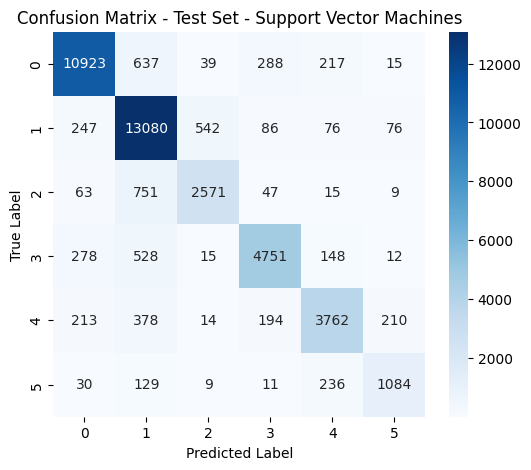

In [ ]:
# Use TF-IDF approach
vectorizer = TfidfVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
X_val = vectorizer.transform(validate_df['text'])

# Convert labels into numeric as support vector classifier does not use one hot encoded labels
y_train = np.argmax(np.array(train_df['label'].tolist()), axis=1)
y_test = np.argmax(np.array(test_df['label'].tolist()), axis=1)
y_val = np.argmax(np.array(validate_df['label'].tolist()), axis=1)

# Hyperparameter tuning using validation dataset
C_values = [0.1, 0.5, 1.0, 5.0]
best_C = None
best_val_acc = 0
best_model_svc = None

for C in C_values:
    classifier_svc = LinearSVC(C=C)  # C is the regularization parameter that can be adjusted
    classifier_svc.fit(X_train, y_train)  
    
    y_val_pred = classifier_svc.predict(X_val)  # Predictions
    val_acc = accuracy_score(y_val, y_val_pred)  # Validation accuracy calculated
    
    print(f"C={C} | Validation Accuracy: {val_acc:.4f}")

    # Remove the bad performing model until the best performing model is reached
    if val_acc > best_val_acc:
        best_C = C
        best_val_acc = val_acc
        best_model_svc = classifier_svc

print(f"\nBest C: {best_C} with Validation Accuracy: {best_val_acc:.4f}")

# Test using the best model on set
y_test_pred = best_model_svc.predict(X_test)

print("\nFinal Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nFinal Test Classification Report - Support Vector Machines:\n", classification_report(y_test, y_test_pred))


# Confusion matrix calculation for further analysis of model on test set
test_cm_svc = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set - Support Vector Machines - TF-IDF")
plt.show()

Step 3 - Part 3: Decision Tree with Bag of Words / TF-IDF

ccp_alpha=0.0001 | Validation Accuracy: 0.8497
ccp_alpha=0.001 | Validation Accuracy: 0.8494
ccp_alpha=0.01 | Validation Accuracy: 0.3385
ccp_alpha=0.1 | Validation Accuracy: 0.3385

Best CCP Alpha: 0.0001 with Validation Accuracy: 0.8497

Final Test Accuracy: 0.8475914019767776

Final Test Classification Report - Decision Tree:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89     12119
           1       0.83      0.91      0.87     14107
           2       0.83      0.65      0.73      3456
           3       0.83      0.84      0.83      5732
           4       0.79      0.83      0.81      4771
           5       0.88      0.60      0.71      1499

    accuracy                           0.85     41684
   macro avg       0.84      0.78      0.81     41684
weighted avg       0.85      0.85      0.85     41684



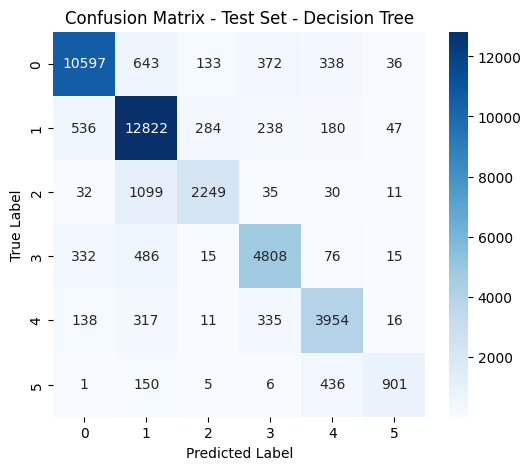

In [ ]:
# Use bag of words approach
vectorizer = CountVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
X_val = vectorizer.transform(validate_df['text'])

# Convert labels into numeric as Decision Trees does not use one hot encoded labels
y_train = np.argmax(np.array(train_df['label'].tolist()), axis=1)
y_test = np.argmax(np.array(test_df['label'].tolist()), axis=1)
y_val = np.argmax(np.array(validate_df['label'].tolist()), axis=1)

# Hyperparameter tuning using validation dataset
ccp_values = [0.0001, 0.001, 0.01, 0.1]
best_ccp = None
best_val_acc = 0
best_model_dt = None

for ccp in ccp_values:
    classifier_dt = DecisionTreeClassifier(ccp_alpha=ccp)  # CCP Alpha is the regularization parameter that can be adjusted
    classifier_dt.fit(X_train, y_train)  
    
    y_val_pred = classifier_dt.predict(X_val)  # Predictions
    val_acc = accuracy_score(y_val, y_val_pred)  # Validation accuracy calculated
    
    print(f"ccp_alpha={ccp} | Validation Accuracy: {val_acc:.4f}")

    # Remove the bad performing model until the best performing model is reached
    if val_acc > best_val_acc:
        best_ccp = ccp
        best_val_acc = val_acc
        best_model_dt = classifier_dt

print(f"\nBest CCP Alpha: {best_ccp} with Validation Accuracy: {best_val_acc:.4f}")

# Test using the best model on set
y_test_pred = best_model_dt.predict(X_test)

print("\nFinal Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nFinal Test Classification Report - Decision Tree:\n", classification_report(y_test, y_test_pred))


# Confusion matrix calculation for further analysis of model on test set
test_cm_dt = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set - Decision Tree - BoW")
plt.show()

ccp_alpha=0.0001 | Validation Accuracy: 0.8493
ccp_alpha=0.001 | Validation Accuracy: 0.8479
ccp_alpha=0.01 | Validation Accuracy: 0.3385
ccp_alpha=0.1 | Validation Accuracy: 0.3385

Best CCP Alpha: 0.0001 with Validation Accuracy: 0.8493

Final Test Accuracy: 0.8475914019767776

Final Test Classification Report - Decision Tree:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89     12119
           1       0.83      0.91      0.87     14107
           2       0.83      0.65      0.73      3456
           3       0.83      0.84      0.83      5732
           4       0.79      0.83      0.81      4771
           5       0.88      0.60      0.71      1499

    accuracy                           0.85     41684
   macro avg       0.84      0.78      0.81     41684
weighted avg       0.85      0.85      0.85     41684



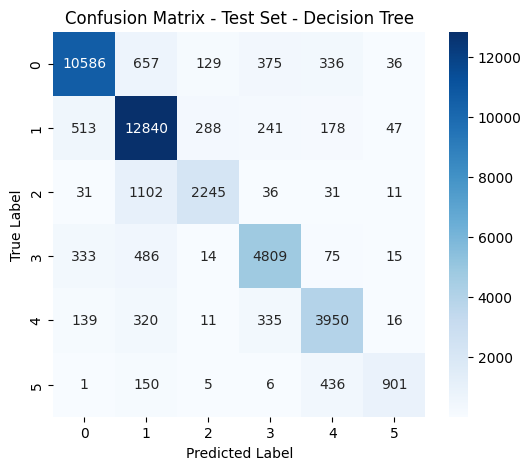

In [ ]:
# Use TF-IDF approach
vectorizer = TfidfVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
X_val = vectorizer.transform(validate_df['text'])

# Convert labels into numeric as Decision Trees does not use one hot encoded labels
y_train = np.argmax(np.array(train_df['label'].tolist()), axis=1)
y_test = np.argmax(np.array(test_df['label'].tolist()), axis=1)
y_val = np.argmax(np.array(validate_df['label'].tolist()), axis=1)

# Hyperparameter tuning using validation dataset
ccp_values = [0.0001, 0.001, 0.01, 0.1]
best_ccp = None
best_val_acc = 0
best_model_dt = None

for ccp in ccp_values:
    classifier_dt = DecisionTreeClassifier(ccp_alpha=ccp)  # CCP Alpha is the regularization parameter that can be adjusted
    classifier_dt.fit(X_train, y_train)  
    
    y_val_pred = classifier_dt.predict(X_val)  # Predictions
    val_acc = accuracy_score(y_val, y_val_pred)  # Validation accuracy calculated
    
    print(f"ccp_alpha={ccp} | Validation Accuracy: {val_acc:.4f}")

    # Remove the bad performing model until the best performing model is reached
    if val_acc > best_val_acc:
        best_ccp = ccp
        best_val_acc = val_acc
        best_model_dt = classifier_dt

print(f"\nBest CCP Alpha: {best_ccp} with Validation Accuracy: {best_val_acc:.4f}")

# Test using the best model on set
y_test_pred = best_model_dt.predict(X_test)

print("\nFinal Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nFinal Test Classification Report - Decision Tree:\n", classification_report(y_test, y_test_pred))


# Confusion matrix calculation for further analysis of model on test set
test_cm_dt = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set - Decision Tree - TF/IDF")
plt.show()

Step 3 - Part 4: Stochastic Gradient Descent (SGD) with Bag of Words / TF-IDF

Alpha=1e-05 | Validation Accuracy: 0.8483
Alpha=0.0001 | Validation Accuracy: 0.8459
Alpha=0.001 | Validation Accuracy: 0.8467
Alpha=0.01 | Validation Accuracy: 0.8480

Best Alpha: 1e-05 with Validation Accuracy: 0.8483

Final Test Accuracy: 0.8472795317148066

Final Test Classification Report - Stochastic Gradient Descent:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     12119
           1       0.91      0.85      0.88     14107
           2       0.70      0.82      0.75      3456
           3       0.75      0.86      0.80      5732
           4       0.86      0.74      0.79      4771
           5       0.75      0.74      0.75      1499

    accuracy                           0.85     41684
   macro avg       0.81      0.82      0.81     41684
weighted avg       0.85      0.85      0.85     41684



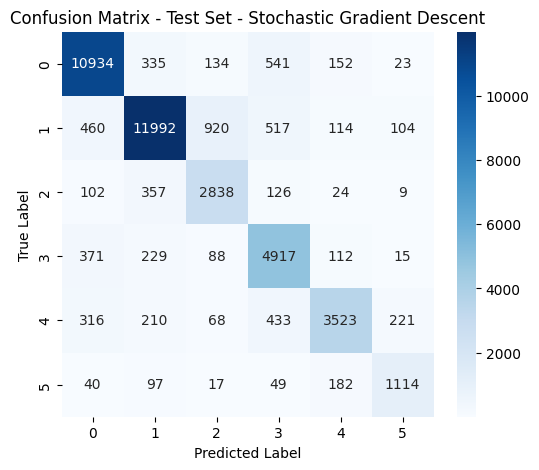

In [ ]:
# Use bag of words approach
vectorizer = CountVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
X_val = vectorizer.transform(validate_df['text'])

# Convert labels into numeric as SGD Classifier does not use one hot encoded labels
y_train = np.argmax(np.array(train_df['label'].tolist()), axis=1)
y_test = np.argmax(np.array(test_df['label'].tolist()), axis=1)
y_val = np.argmax(np.array(validate_df['label'].tolist()), axis=1)

# Hyperparameter tuning using validation dataset
alpha_values = [0.00001, 0.0001, 0.001, 0.01]
best_alpha = None
best_val_acc = 0
best_model_sgd = None

for alpha in alpha_values:
    classifier_sgd = SGDClassifier(alpha=alpha, loss="perceptron")  # Alpha is the smoothing parameter that can be adjusted
    classifier_sgd.fit(X_train, y_train)  
    
    y_val_pred = classifier_sgd.predict(X_val)  # Predictions
    val_acc = accuracy_score(y_val, y_val_pred)  # Validation accuracy calculated
    
    print(f"Alpha={alpha} | Validation Accuracy: {val_acc:.4f}")

    # Remove the bad performing model until the best performing model is reached
    if val_acc > best_val_acc:
        best_alpha = alpha
        best_val_acc = val_acc
        best_model_sgd = classifier_sgd

print(f"\nBest Alpha: {best_alpha} with Validation Accuracy: {best_val_acc:.4f}")

# Test using the best model on set
y_test_pred = best_model_sgd.predict(X_test)

print("\nFinal Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nFinal Test Classification Report - Stochastic Gradient Descent:\n", classification_report(y_test, y_test_pred))

# Confusion matrix calculation for further analysis of model on test set
test_cm_sgd = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set - Stochastic Gradient Descent - BoW")
plt.show()

Alpha=1e-05 | Validation Accuracy: 0.8505
Alpha=0.0001 | Validation Accuracy: 0.8464
Alpha=0.001 | Validation Accuracy: 0.8492
Alpha=0.01 | Validation Accuracy: 0.8453

Best Alpha: 1e-05 with Validation Accuracy: 0.8505

Final Test Accuracy: 0.8481191824201132

Final Test Classification Report - Stochastic Gradient Descent:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90     12119
           1       0.88      0.88      0.88     14107
           2       0.75      0.74      0.74      3456
           3       0.79      0.84      0.81      5732
           4       0.78      0.82      0.80      4771
           5       0.82      0.63      0.71      1499

    accuracy                           0.85     41684
   macro avg       0.82      0.80      0.81     41684
weighted avg       0.85      0.85      0.85     41684



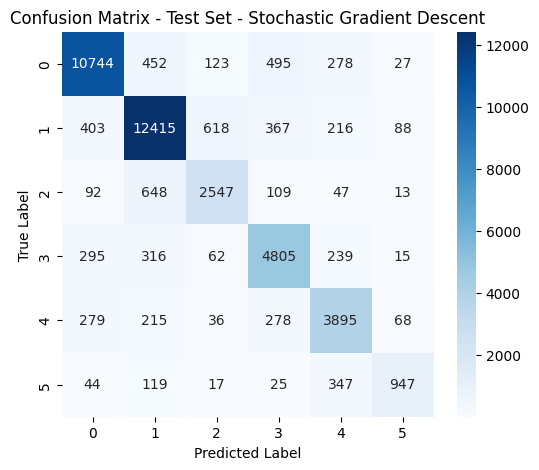

In [ ]:
# Use TF-IDF approach
vectorizer = TfidfVectorizer(max_features=1000)

X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
X_val = vectorizer.transform(validate_df['text'])

# Convert labels into numeric as SGD Classifier does not use one hot encoded labels
y_train = np.argmax(np.array(train_df['label'].tolist()), axis=1)
y_test = np.argmax(np.array(test_df['label'].tolist()), axis=1)
y_val = np.argmax(np.array(validate_df['label'].tolist()), axis=1)

# Hyperparameter tuning using validation dataset
alpha_values = [0.00001, 0.0001, 0.001, 0.01]
best_alpha = None
best_val_acc = 0
best_model_sgd = None

for alpha in alpha_values:
    classifier_sgd = SGDClassifier(alpha=alpha, loss="perceptron")  # Alpha is the smoothing parameter that can be adjusted
    classifier_sgd.fit(X_train, y_train)  
    
    y_val_pred = classifier_sgd.predict(X_val)  # Predictions
    val_acc = accuracy_score(y_val, y_val_pred)  # Validation accuracy calculated
    
    print(f"Alpha={alpha} | Validation Accuracy: {val_acc:.4f}")

    # Remove the bad performing model until the best performing model is reached
    if val_acc > best_val_acc:
        best_alpha = alpha
        best_val_acc = val_acc
        best_model_sgd = classifier_sgd

print(f"\nBest Alpha: {best_alpha} with Validation Accuracy: {best_val_acc:.4f}")

# Test using the best model on set
y_test_pred = best_model_sgd.predict(X_test)

print("\nFinal Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nFinal Test Classification Report - Stochastic Gradient Descent:\n", classification_report(y_test, y_test_pred))

# Confusion matrix calculation for further analysis of model on test set
test_cm_sgd = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set - Stochastic Gradient Descent - TF-IDF")
plt.show()

Step 3 - Part 5: Recurent Neural Networks (RNNs) with Tokenizer

In [10]:
# Check if an available GPU exists
physical_devices = tf.config.list_physical_devices('GPU')
# Enable dynamic memory growth to save memory
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [11]:
# Initalising training tokenizer structure and saving it as json for possible future use
vocab_size = 1000
max_length = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_df['text'].tolist())

X_train_seq = tokenizer.texts_to_sequences(train_df['text'].tolist())
X_val_seq   = tokenizer.texts_to_sequences(validate_df['text'].tolist())
X_test_seq  = tokenizer.texts_to_sequences(test_df['text'].tolist())

X_train = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val   = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test  = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as json_file:
    json_file.write(tokenizer_json)

In [ ]:
# Using the vocab size to convert one hot encoded labels into list structure
y_train = np.array(train_df['label'].tolist())
y_val   = np.array(validate_df['label'].tolist())
y_test  = np.array(test_df['label'].tolist())

num_classes = y_train.shape[1]
print("X_train: ", X_train[3])
print("y_train: ", y_train[3])
print("num_classes: ", num_classes)

In [17]:
# Designing of the RNN (Bidirectional LSTM) model
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),  
    Dropout(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),  
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),  
    Dropout(0.3),
    Dense(64, activation='relu'), 
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          128000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 100, 128)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_11 (Bidirecti  (None, 100, 256)         263168    
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 100, 256)          0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 100, 256)         394240    
 onal)                                                           
                                                      

In [18]:
# Training the model with data
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/5
5211/5211 [==============================] - 408s 76ms/step - loss: 0.3383 - accuracy: 0.8609 - val_loss: 0.2179 - val_accuracy: 0.8951
Epoch 2/5
5211/5211 [==============================] - 436s 84ms/step - loss: 0.2239 - accuracy: 0.8953 - val_loss: 0.2103 - val_accuracy: 0.8965
Epoch 3/5
5211/5211 [==============================] - 464s 89ms/step - loss: 0.2157 - accuracy: 0.8977 - val_loss: 0.2091 - val_accuracy: 0.8970
Epoch 4/5
5211/5211 [==============================] - 495s 95ms/step - loss: 0.2111 - accuracy: 0.8986 - val_loss: 0.2081 - val_accuracy: 0.8990
Epoch 5/5
5211/5211 [==============================] - 469s 90ms/step - loss: 0.2074 - accuracy: 0.8994 - val_loss: 0.2078 - val_accuracy: 0.8985


1303/1303 [==============================] - 45s 34ms/step - loss: 0.2084 - accuracy: 0.8981
Test Loss, Test Accuracy: [0.20836114883422852, 0.8981310725212097]
1303/1303 [==============================] - 45s 33ms/step
Comparing the first 10 test predictions:
Test case 1:
  Predicted Label: 3
  Actual Label:    [0. 0. 0. 1. 0. 0.]
-------------------------------------------------
Test case 2:
  Predicted Label: 0
  Actual Label:    [1. 0. 0. 0. 0. 0.]
-------------------------------------------------
Test case 3:
  Predicted Label: 4
  Actual Label:    [0. 0. 0. 0. 1. 0.]
-------------------------------------------------
Test case 4:
  Predicted Label: 0
  Actual Label:    [1. 0. 0. 0. 0. 0.]
-------------------------------------------------
Test case 5:
  Predicted Label: 3
  Actual Label:    [0. 0. 0. 1. 0. 0.]
-------------------------------------------------
Test case 6:
  Predicted Label: 1
  Actual Label:    [0. 1. 0. 0. 0. 0.]
-------------------------------------------------
T

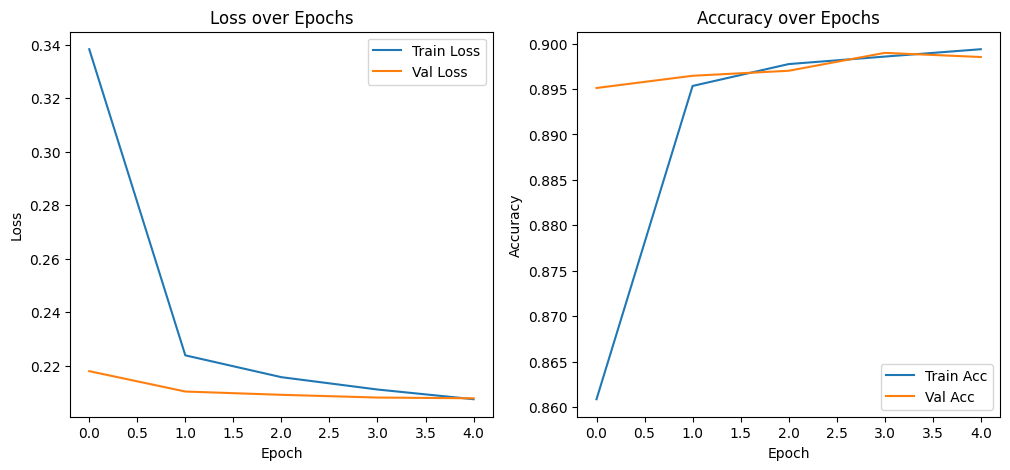

In [19]:
# Evaluating the results via test set
results = model.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)

# Predict on the test set
predictions = model.predict(X_test)

# Convert predictions to class indices (assumes a softmax output)
predicted_labels = np.argmax(predictions, axis=1)

# If y_test is part of a DataFrame column, you might need to convert it to a NumPy array:

print("Comparing the first 10 test predictions:")
for i in range(10):
    print(f"Test case {i+1}:")
    print(f"  Predicted Label: {predicted_labels[i]}")
    print(f"  Actual Label:    {y_test[i]}")
    print("-------------------------------------------------")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Step 4: Saving the Best Performing Model (which is the RNN with Bidirectional LSTM layers)

In [ ]:
model.save("RNN_Tweet_Classifier.h5")